# House Prices

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
x_train = pd.read_csv('./train.csv')
x_test = pd.read_csv('./test.csv')
y_train = x_train.iloc[:, -1]

In [3]:
x_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# x_train.info()

In [5]:
#x_train.describe()

I'll se whether features contains outliers or don't, to know which is the better way to replace them. 

In [6]:
numeric = x_train.select_dtypes('number').columns
categorical = x_train.select_dtypes('object').astype('category').columns

In [7]:
# Missing values in numeric features
mnum = x_train[numeric].isnull().sum()/len(x_train)
mnum[mnum>0]

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

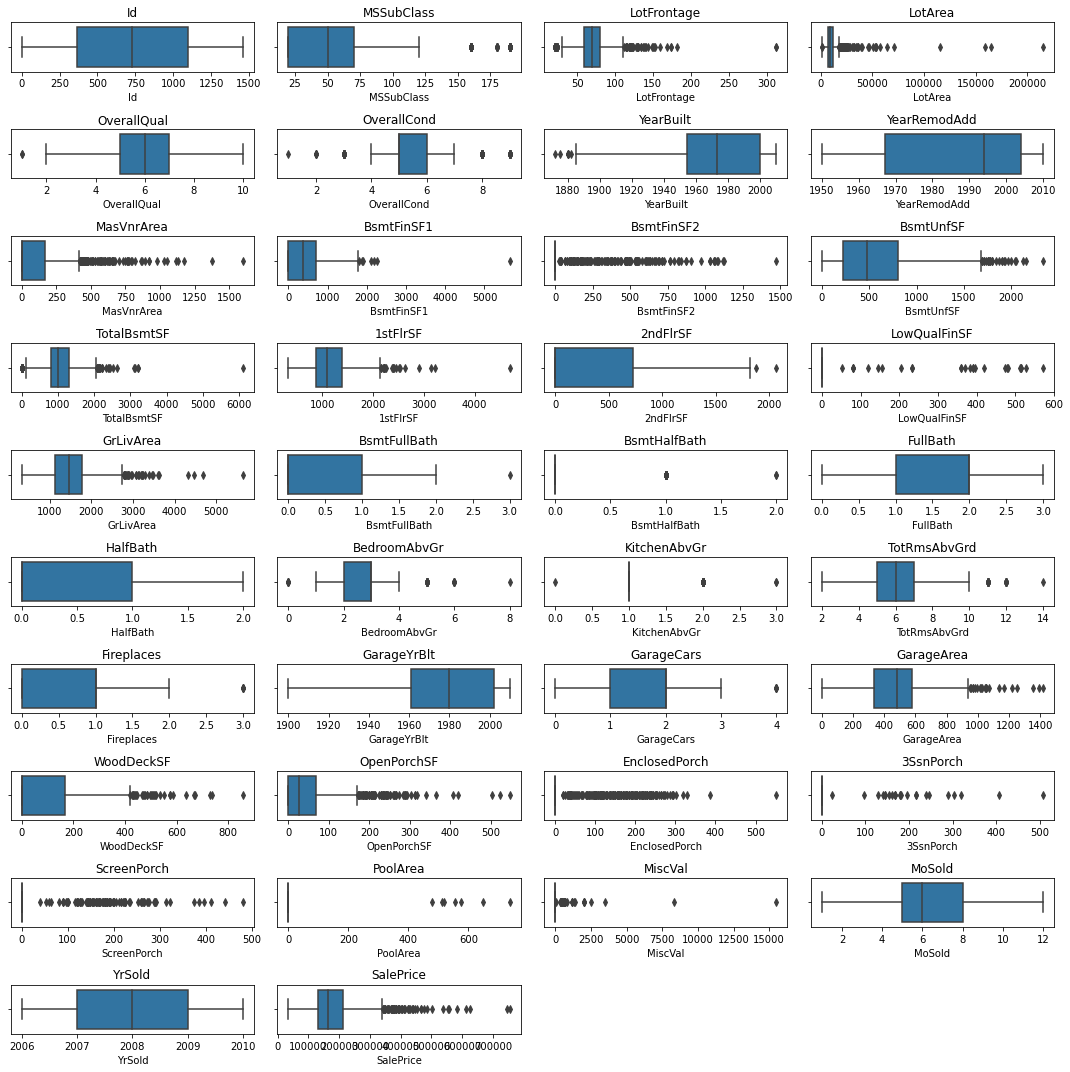

In [8]:
color = sns.color_palette('Set2')
plt.figure(figsize = (15, 15))
for i in range(0, len(numeric)):
    ax = plt.subplot(10, 4, i+1)
    sns.boxplot(x_train[numeric[i]])
    plt.title(numeric[i])
plt.tight_layout()
plt.show()

There are three numeric columns with missing values, i'll replace missing values by median in LotFrontage and MasVnrArea
and i'll check whether in general, garages were built in the same year the house were built.

In [9]:
len(x_train[(x_train['GarageYrBlt'] == x_train['YearBuilt'])])/len(x_train)

0.7458904109589041

As we can see, the 75% of garages were built in the same year the houses were built, so i'll replace nan by the year of house were built

In [10]:
x_train['LotFrontage'] = x_train['LotFrontage'].fillna(x_train['LotFrontage'].median(skipna=True))
x_train['MasVnrArea'] = x_train['MasVnrArea'].fillna(x_train['MasVnrArea'].median(skipna=True))

In [11]:
x_train['GarageYrBlt'][x_train['GarageYrBlt'].isnull() == True] = x_train['YearBuilt'][x_train['GarageYrBlt'].isnull() == True]

In [12]:
mnum = x_train[numeric].isnull().sum()/len(x_train)
mnum[mnum > 0]

Series([], dtype: float64)

We already deal with missing values in numeric columns. Now, i'll deal with missing values in categorical columns. Checking the information about columns i noticed that NA represent in some features the lack of that specific feature in the house, so i'll replace it by 'NONE' in those features; and for other, i'll replace it by mode.

In [13]:
nafeatures = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 
             'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
categorical2 = categorical.drop(nafeatures)    

In [14]:
for i in range(len(nafeatures)):
    x_train[nafeatures[i]] = x_train[nafeatures[i]].fillna(f'{nafeatures[i]} None')
    x_test[nafeatures[i]] = x_test[nafeatures[i]].fillna(f'{nafeatures[i]} None')

In [15]:
for i in categorical2:
    x_train[i] = x_train[i].fillna(x_train[i].mode()[0])
    x_test[i] = x_test[i].fillna(x_test[i].mode()[0])

I already deal with missing values in train data set, now let's do the same with test data set

In [16]:
tnull = x_test[x_test.select_dtypes('number').columns].isnull().sum()/len(x_test)
tnull[tnull>0]

LotFrontage     0.155586
MasVnrArea      0.010281
BsmtFinSF1      0.000685
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
GarageYrBlt     0.053461
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

In [17]:
x_test['MasVnrArea'] = x_test['MasVnrArea'].fillna(x_test['MasVnrArea'].median(skipna=True))
x_test['TotalBsmtSF'] = x_test['TotalBsmtSF'].fillna(x_test['TotalBsmtSF'].median(skipna=True))
x_test['GarageArea'] = x_test['GarageArea'].fillna(x_test['GarageArea'].median(skipna=True))
x_test['GarageYrBlt'][x_test['GarageYrBlt'].isnull() == True] = x_test['YearBuilt'][x_test['GarageYrBlt'].isnull() == True]

In [18]:
#x_train.info()

I aready deal with all missing values, now, I'm going to see the relation between the Sale prices and the predictor features. 

For numeric values i'll use scatterplot

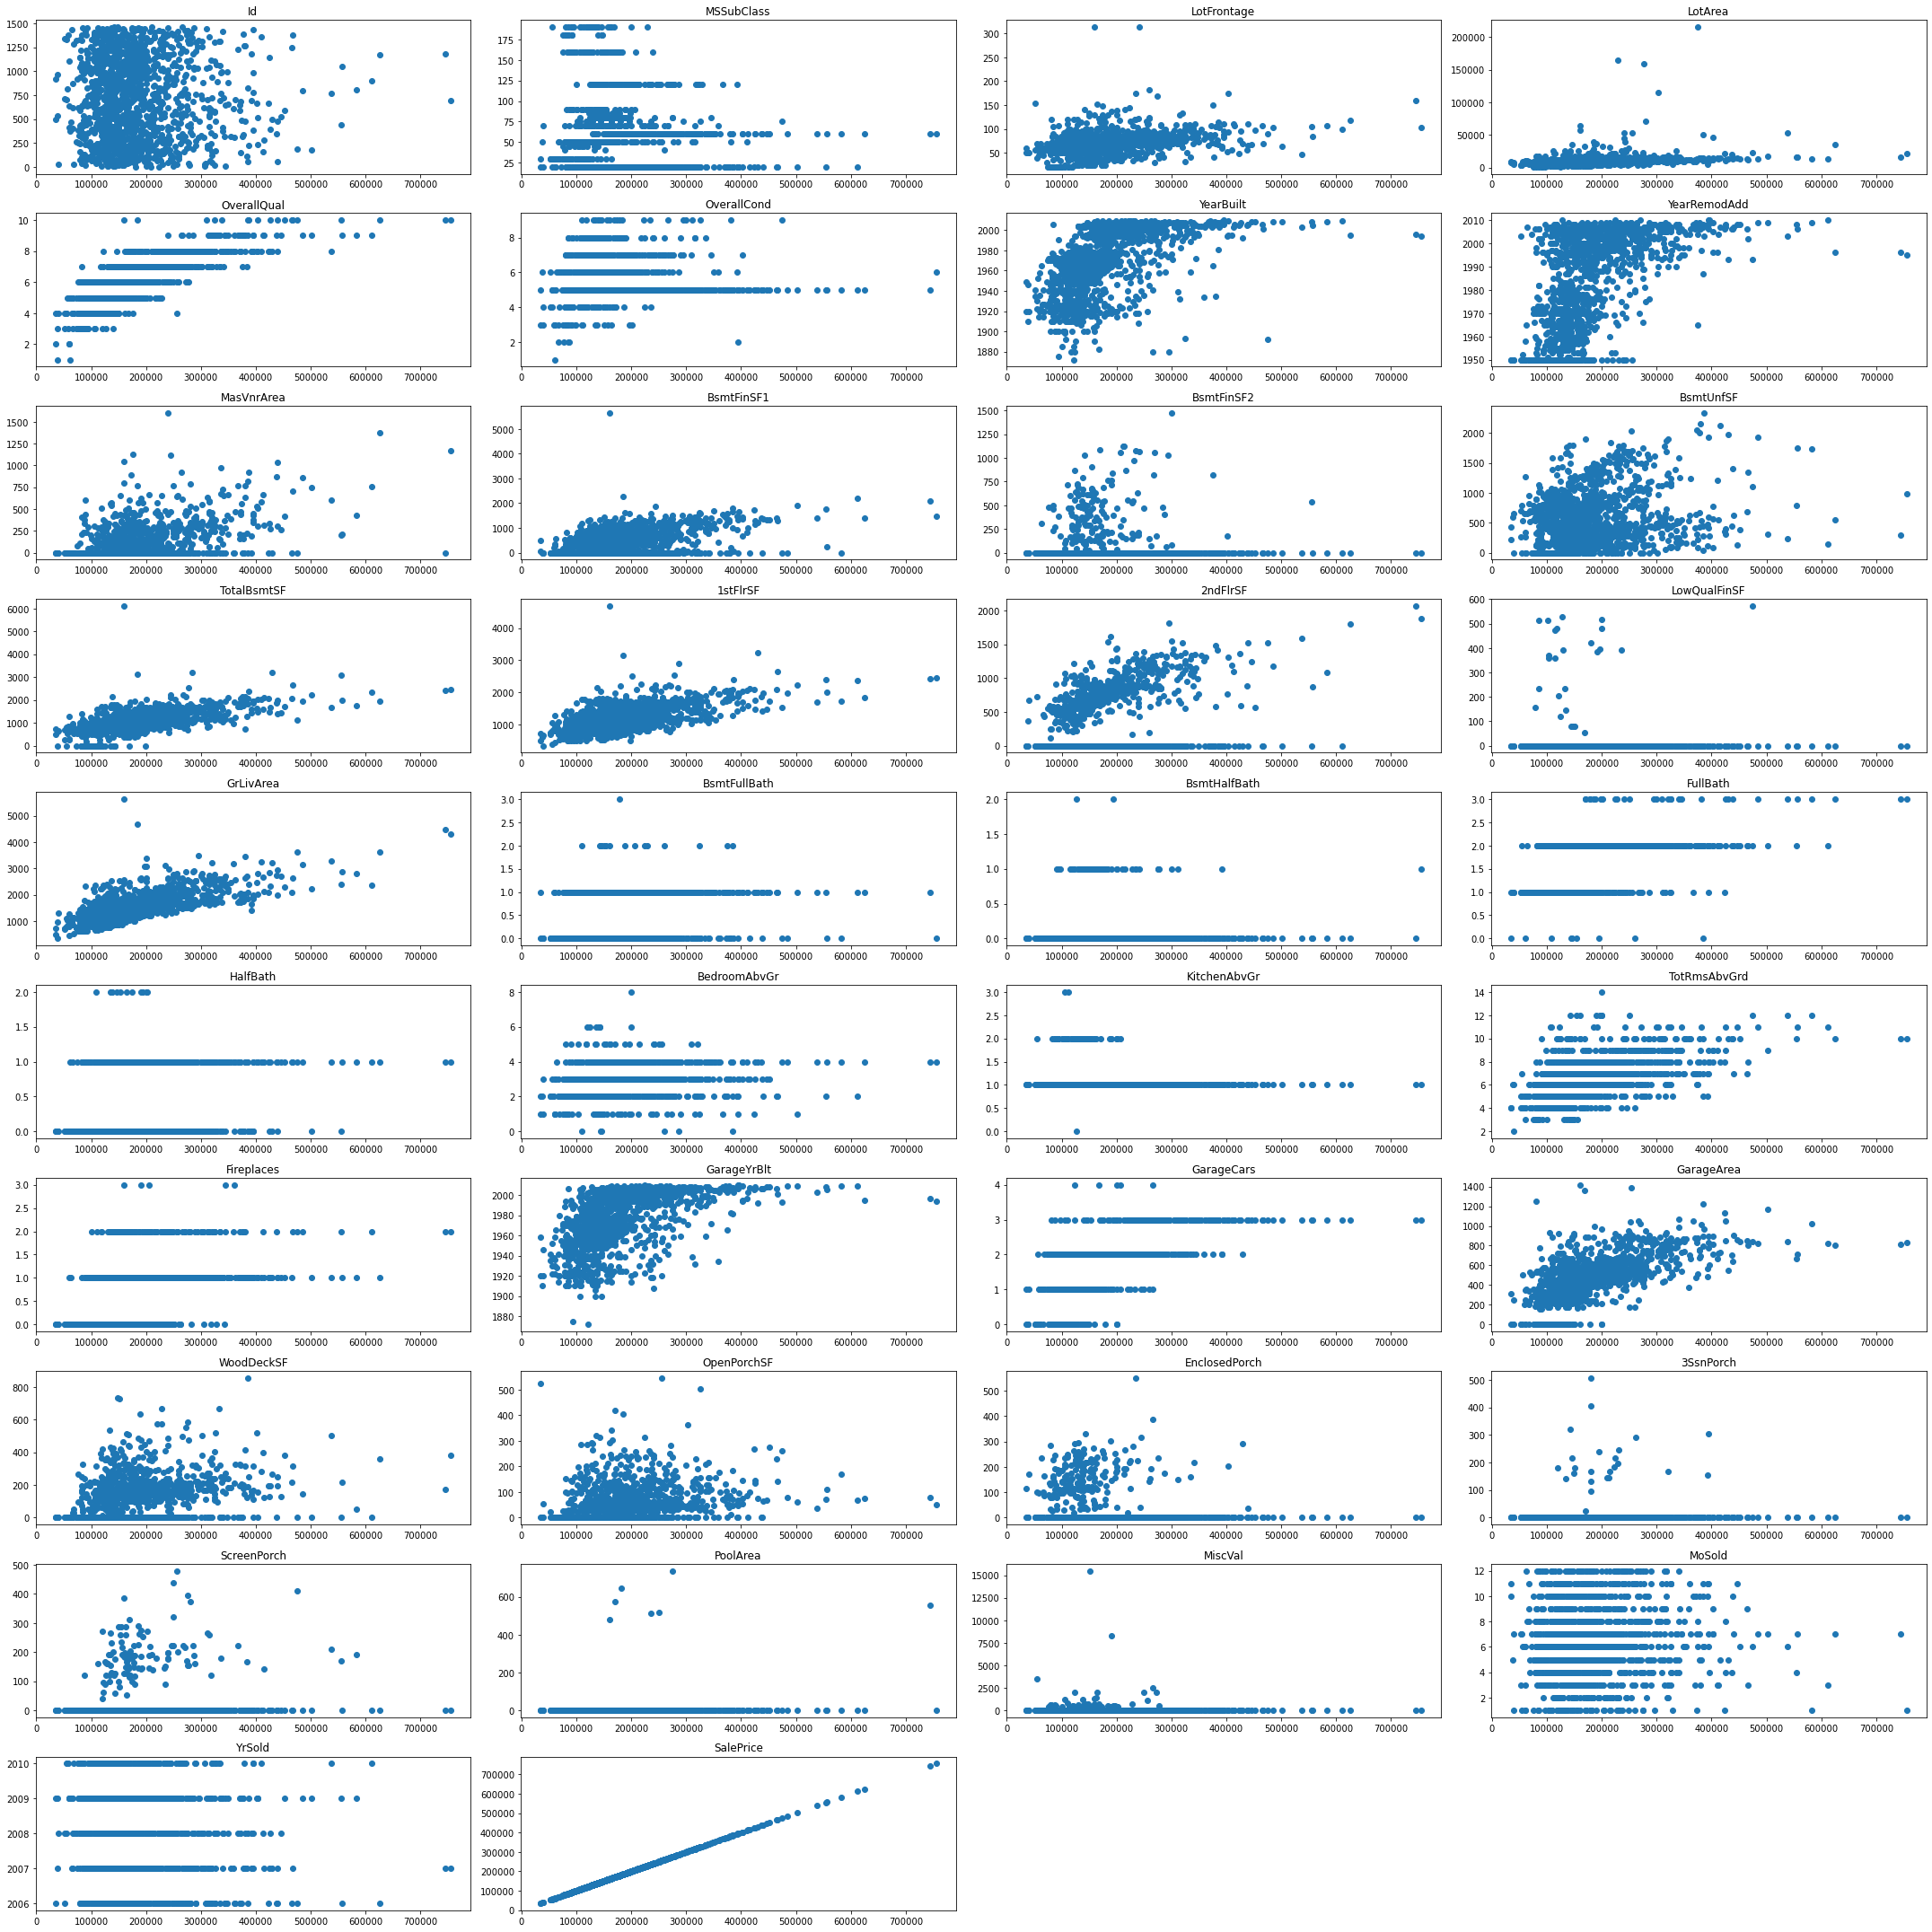

In [19]:
plt.figure(figsize=(30, 30))
for i in range(0, len(numeric)):
    ax = plt.subplot(10, 4, i+1)
    plt.scatter(y_train, x_train[numeric[i]])
    plt.title(numeric[i])
plt.tight_layout()
plt.show()

let's going to see also with pearson correlation

In [20]:
corr = x_train[numeric].corr().iloc[:, -1]
numeric2 = corr[corr>0.4]
numeric2 = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'SalePrice']

In [21]:
#x_train.info()

In [22]:
numeric = numeric.drop(numeric2)

In [23]:
#Dropping numeric columns that aren't enough relevant
x_train.drop(numeric, axis = 1, inplace = True)
x_test.drop(numeric, axis = 1,  inplace = True)

Now, i'm going to analyze categorical features to drop those that are not relevant for this model

In [24]:
#for i in range(len(categorical)):
    #x_train.boxplot(by = categorical[i],  column = 'SalePrice')
# I'll take all categorical variables, looks like if all categorical features were relevant

In [25]:
# Normalizing data

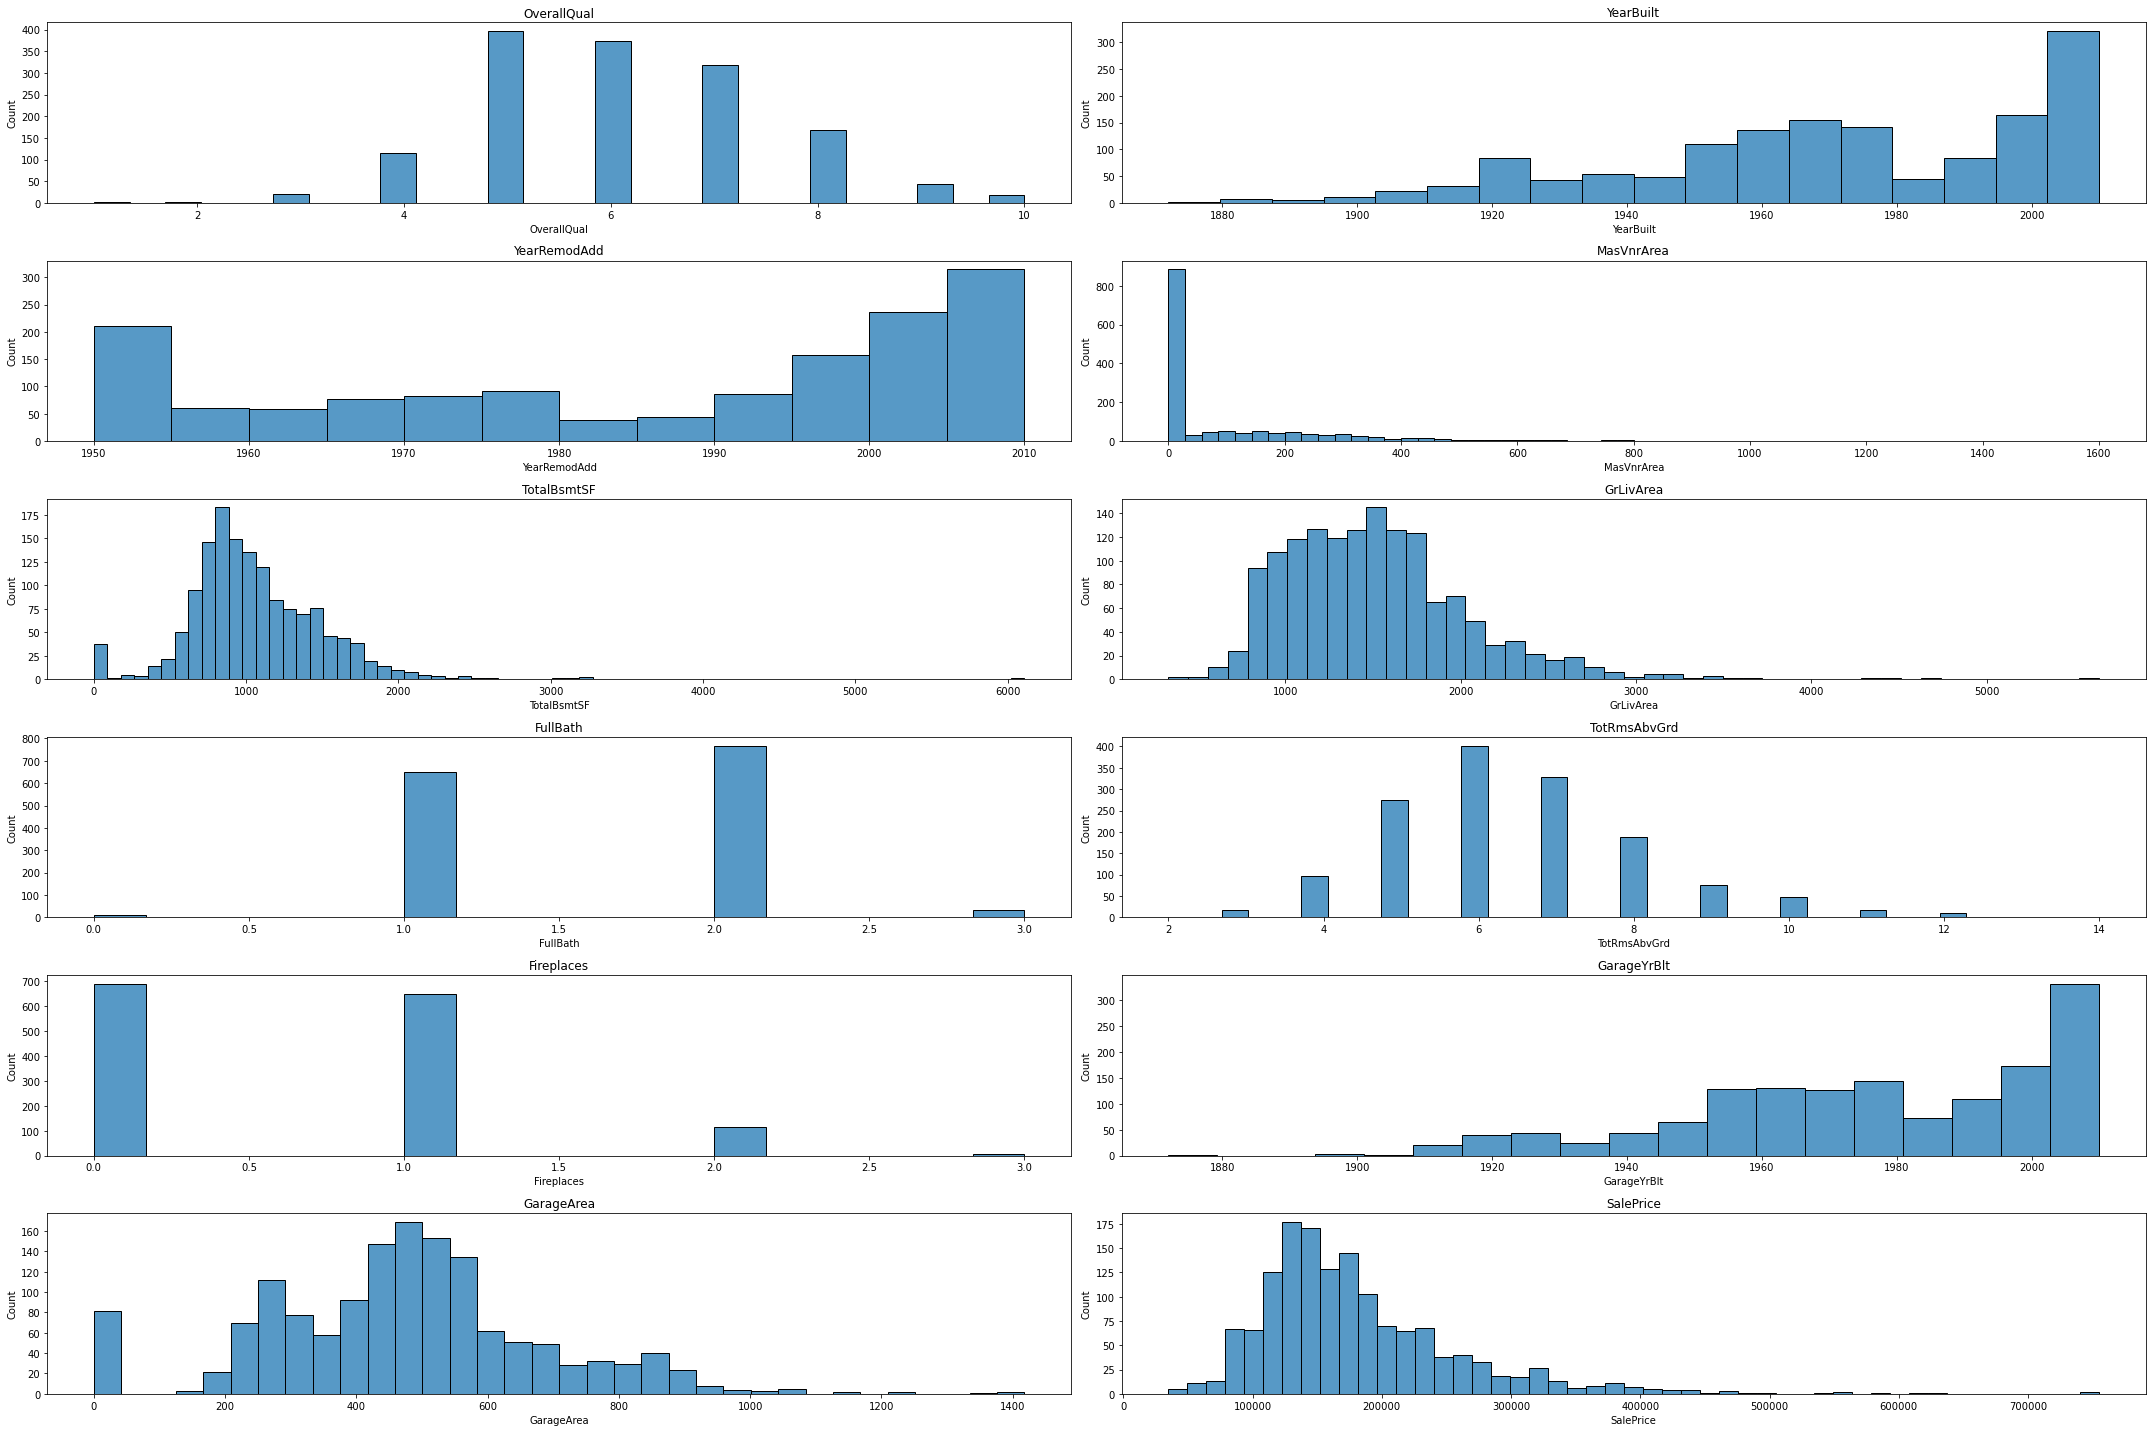

In [ ]:
plt.figure(figsize=(30,20))
for i in range(len(numeric2)):
    plt.subplot(6, 2, i+1)
    sns.histplot(x_train[numeric2[i]])
    plt.title(f'{numeric2[i]}')
plt.tight_layout()
plt.show()

In [ ]:
# Data is not normal distributed, so i'll use quantile transformer to normalize data.
x_train.drop('SalePrice', axis = 1, inplace = True)
numeric2.remove('SalePrice')

qt = QuantileTransformer()
x_train[numeric2] = qt.fit_transform(x_train[numeric2])
x_test[numeric2] = qt.transform(x_test[numeric2])

In [ ]:
# plt.figure(figsize=(30,20))
# for i in range(len(numeric2)):
#     plt.subplot(6, 2, i+1)
#     sns.histplot(x_train[numeric2[i]])
#     plt.title(f'{numeric2[i]}')
# plt.tight_layout()
# plt.show()

Now i'll encode categorical variable

In [ ]:
oh = OneHotEncoder(drop='first')

# Train
train = pd.DataFrame(oh.fit_transform(x_train[categorical]).toarray())
x_train.drop(categorical, axis = 1, inplace = True)

# Test 
test = pd.DataFrame(oh.transform(x_test[categorical]).toarray())
x_test.drop(categorical, axis = 1, inplace = True)

print(train.shape)
print(test.shape)

(1460, 222)
(1459, 222)


In [ ]:
x_traind = pd.concat([x_train, train], axis = 1)
x_testd = pd.concat([x_test, test], axis = 1)

In [ ]:
x_traind.head(1)

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,...,212,213,214,215,216,217,218,219,220,221
0,0.734234,0.795796,0.724224,0.79029,0.324324,0.701702,0.714715,0.831832,0.0,0.78979,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [32]:
xgbr = XGBRegressor()
parameters = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3, 4, 5, 6],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]  
}

rsearch = RandomizedSearchCV(xgbr, param_distributions=parameters, cv=5, scoring= None)
rsearch.fit(x_traind, y_train)
print(rsearch.best_params_)
print(rsearch.best_score_)

{'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.4}
0.8748512221241409


In [33]:
house_p = rsearch.predict(x_testd)

In [34]:
id_house = pd.read_csv('test.csv')
id_house = id_house.

In [35]:
result = pd.DataFrame({'id': id_house, 'SalePrice': house_p})
result.head()

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)